## 2.4 Entrainement d'un agent avec DQN

In [1]:
# CHARGEMENT DU DATASET

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

end_date = datetime(year=2025, month=3, day=1)
start_date = datetime(year=2023, month=1, day=1)

ticker = "^IXIC"

df = yf.download(
    tickers=ticker,
    start=start_date,
    end=end_date,
    interval="1d",
    group_by="ticker",
    auto_adjust=True,
    progress=False
)
df = df['^IXIC']
df

Price,Open,High,Low,Close,Volume
Date,,,,,
2023-01-03,10562.059570,10613.059570,10309.160156,10386.980469,4780650000
2023-01-04,10467.820312,10515.219727,10337.639648,10458.759766,5085380000
2023-01-05,10390.309570,10393.219727,10295.250000,10305.240234,4764270000
2023-01-06,10363.959961,10604.139648,10265.040039,10569.290039,5199780000
2023-01-09,10662.099609,10807.259766,10619.120117,10635.650391,5132190000
...,...,...,...,...,...
2025-02-24,19590.849609,19644.230469,19275.460938,19286.929688,7414760000
2025-02-25,19242.609375,19256.349609,18871.519531,19026.390625,7991440000
2025-02-26,19109.320312,19286.019531,18966.460938,19075.259766,7034450000


In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import time
import gymnasium as gym
import gym_anytrading


# REPLAY BUFFER
class ReplayBuffer:
    def __init__(self, capacity=50_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)


# RÉSEAU DQN
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
           nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim)
        )

    def forward(self, x):
        return self.net(x)


# SÉLECTION D’ACTION (ε-greedy)

def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32)
            return policy_net(state).argmax().item()



# OPTIMISATION DU MODÈLE
def optimize_model():
    if len(replay_buffer) < batch_size:
        return

    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()

    with torch.no_grad():
        max_next_q = target_net(next_states).max(1)[0]
        target_q = rewards + gamma * max_next_q * (1 - dones)

    loss = nn.SmoothL1Loss()(q_values, target_q)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


# ENVIRONNEMENT stocks-v0

env = gym.make(
    "stocks-v0",
    df=df,                   
    window_size=30,
    frame_bound=(30, len(df))
)


state_shape = env.observation_space.shape    
state_dim = np.prod(state_shape)            
action_dim = env.action_space.n              


# INITIALISATION
policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
replay_buffer = ReplayBuffer()

gamma = 0.99
batch_size = 64

epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995

TAU = 0.005
episodes = 300



# BOUCLE D’ENTRAÎNEMENT
profits = []
success_cumulative = []


success_count = 0
start_time = time.time()

for episode in range(episodes):
    state, _ = env.reset()
    state = state.flatten()

    done = False
    total_reward = 0

    while not done:
        action = select_action(state, epsilon)

        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = next_state.flatten()

    
        reward = np.tanh(reward)

        done = truncated

        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        optimize_model()

        for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                TAU * policy_param.data + (1.0 - TAU) * target_param.data
            )

    profits.append(info['total_profit'])

    if info['total_profit'] > 0:
        success_count += 1
    
    success_cumulative.append(success_count / (episode + 1))  

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    print(
        f"Episode {episode:03d} | "
        f"Reward: {total_reward:.3f} | "
        f"Profit: {info['total_profit']:.3f} | "
        f"Epsilon: {epsilon:.3f} "
    )

end_time = time.time()
training_time = end_time - start_time
success_rate = success_count / episodes

print(f"\nTemps total d'entraînement : {training_time:.2f} secondes")
print(f"Taux de succès final : {success_cumulative[-1]*100:.2f}%")

env.close()


C:\Users\PC\AppData\Local\Temp\ipykernel_19128\937684416.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  torch.tensor(states, dtype=torch.float32),


Episode 000 | Reward: 22.000 | Profit: 0.222 | Epsilon: 0.995 
Episode 001 | Reward: 14.604 | Profit: 0.171 | Epsilon: 0.990 
Episode 002 | Reward: 15.000 | Profit: 0.213 | Epsilon: 0.985 
Episode 003 | Reward: -0.541 | Profit: 0.163 | Epsilon: 0.980 
Episode 004 | Reward: 21.603 | Profit: 0.217 | Epsilon: 0.975 
Episode 005 | Reward: 29.924 | Profit: 0.220 | Epsilon: 0.970 
Episode 006 | Reward: 29.790 | Profit: 0.263 | Epsilon: 0.966 
Episode 007 | Reward: 28.062 | Profit: 0.225 | Epsilon: 0.961 
Episode 008 | Reward: 24.190 | Profit: 0.259 | Epsilon: 0.956 
Episode 009 | Reward: 24.924 | Profit: 0.254 | Epsilon: 0.951 
Episode 010 | Reward: 26.794 | Profit: 0.227 | Epsilon: 0.946 
Episode 011 | Reward: 15.927 | Profit: 0.216 | Epsilon: 0.942 
Episode 012 | Reward: 16.928 | Profit: 0.196 | Epsilon: 0.937 
Episode 013 | Reward: 16.000 | Profit: 0.246 | Epsilon: 0.932 
Episode 014 | Reward: 25.401 | Profit: 0.264 | Epsilon: 0.928 
Episode 015 | Reward: 7.794 | Profit: 0.192 | Epsilon: 

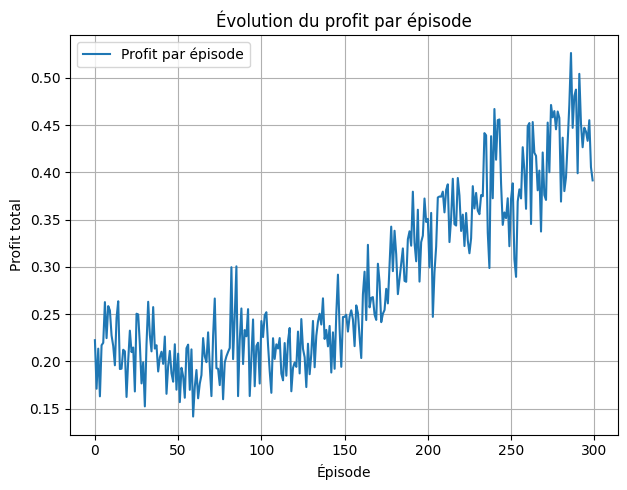

In [3]:
#  TRACER LES COURBES

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(profits, label="Profit par épisode")
plt.xlabel("Épisode")
plt.ylabel("Profit total")
plt.title("Évolution du profit par épisode")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# 2.5 Analyse

- Les résultats montrent que la reward cumulée est globalement positive, ce qui confirme que l’agent prend majoritairement des décisions alignées avec la fonction de récompense définie.

- On note quelques épisodes isolés avec des rewards négatives malgré des profits positifs. Cependant, ces cas restent rares et n’affectent pas la tendance générale de l’apprentissage.

- Une augmentation progressive des rewards et des profits est observée à partir de la première moitié vers la fin de l’entraînement, suggérant que le réseau de neurones a appris à identifier et exploiter des patterns cohérents dans les données de marché. Cette amélioration coïncide avec la diminution du paramètre ε (epsilon), illustrant le passage progressif de l’exploration vers l’exploitation.

- Enfin, le taux de succès final de 100% montre que l’agent a atteint un niveau de performance optimal sur l’ensemble des épisodes d’entraînement, validant l’efficacité de la stratégie apprise.